In [1]:
!module list
################################WITH CONDA

#1 step create environment
# conda -n gputest python=3

#2 activate environment
#conda activate gputest

#3 install kernel for the gpu enbaling (?!)
# pip install ipykernel

#4 set kernel
# python -m ipykernel install --user --name gputest --display-name "gputest"



Currently Loaded Modules:
  1) astro   2) cuda/11.2   3) python/anaconda3/2020.11

 




### Step 1: Import necessary modules and write main functions


In [2]:
import os
import tensorflow
import numpy as np
import matplotlib.pyplot as plt
import time
import random
import yt
import pickle
tik1=time.time()


from datetime import datetime
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.imagenet_utils import decode_predictions, preprocess_input


from tensorflow.keras.layers import Input
from keras.applications.vgg19 import preprocess_input as process_vgg19
from keras.applications.xception import preprocess_input as process_xception
from keras.applications.vgg16 import preprocess_input as process_vgg16
from keras.applications.densenet import preprocess_input as process_DenseNet
##xx







from tensorflow.keras.models import Model
from keras.utils.vis_utils import plot_model
from IPython.display import Image 
from sklearn.decomposition import PCA
from scipy.spatial import distance
from sklearn.neighbors import NearestNeighbors

Image.MAX_IMAGE_PIXELS = None






### Load the Neural Network from the internet or local files
def conv_model(model_name='resnet',show_model=False,use_timing=True):
    t_1=time.time()
    if model_name=='vgg16':   #works 
        model = tensorflow.keras.models.load_model('/data/scratch/rami/models/vgg16/',compile=False)
    elif model_name=='xception': #works
        model = tensorflow.keras.models.load_model('/data/scratch/rami/models/xception/',compile=False)
    elif model_name=='vgg19': #works        
        model = tensorflow.keras.models.load_model('/data/scratch/rami/models/vgg19/',compile=False)
    ##xx
    else:
        print('Incorrect model_name fed to function conv_model')
    t_2=time.time()
    if model!=None:
        for layer in model.layers:
            layer.trainable=False
    t_3=time.time()
    if show_model==True:
        model.summary()
    t_4=time.time()
    if use_timing:
        print('Loading convolutional model:',model_name)
        print('%1.2f sec to load the model parameters'%(t_2-t_1))
        print('%1.2f sec to freeze the model layers'%(t_3-t_2))
        print('%1.2f sec to show the model parameters'%(t_3-t_2))
        
    return model


def load_img_from_pickles(pickle_file='/lustre/astro/rlk/Movie_frames/Ramses/Sink_91/XY/1000AU/Obs_Comp/Image_Center_Primary/Time_Series/Obs_threshold/Zoom_in/'\
                          ,model_name='vgg16'):
    file = open(pickle_file, "rb")
    image = pickle.load(file)
    #X, Y, image = pickle.load(file)
    file.close()
    shape_image=np.shape(image)
    image_rgb=np.zeros(shape=(shape_image[0],shape_image[1],3))
    image_rgb[:,:,0]=image
    image_rgb[:,:,1]=image
    image_rgb[:,:,2]=image
    x = np.expand_dims(image_rgb, axis=0)
    if model_name=='vgg16':  
        x=process_vgg16(x)
    elif model_name=='xception':
        x=process_xception(x)
    elif model_name=='vgg19':
        x=process_vgg19(x) 
    
    return image_rgb,x




 # Delete the neural network 
def delete_model(model, clear_session=True):
    '''removes model!
    '''
    del model
    gc.collect()
    if clear_session: K.clear_session()

def get_neighbors(feature_vector,feature_vectors, k=5):
    '''Function that returns the neighbor distances and their indeces (of the image array corresponding to the images names)'''
    similar_idx = [ distance.euclidean(feature_vector, feat) for feat in feature_vectors ]
    idx_closest = sorted(range(len(similar_idx)), key=lambda k: similar_idx[k])[0:0+k]
    distances=[]
    for i in idx_closest:
        distances.append(similar_idx[i])
    distances=np.array(distances)
    idx_closest=np.array(idx_closest)
    return distances,idx_closest        




# Load an image to the neural network
def load_image(image_path,model,model_name='resnet'):
    '''Load an image an preprocess it, and return the image and the preprocessed input'''
#     print('Model input shape:',model.input_shape[1:3])
    img = image.load_img(image_path, target_size=(224,224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    if model_name=='vgg16':  
        x=process_vgg16(x)
    elif model_name=='xception':
        x=process_xception(x)
    elif model_name=='vgg19':
        x=process_vgg19(x) 
    ##xx
    else:
        print('Incorrect  model_name fed to function load_image')
    return img, np.array(x)

def load_pickle(file='/lustre/astro/rlk/Movie_frames/Ramses/Sink_91/XY/1000AU/Obs_Comp/Image_Center_Primary/Time_Series/Obs_threshold/Zoom_in/'):
    '''Loads a pickle file simply'''
    information=open(file,"rb")
    result=pickle.load(information)
    information.close()
    return result

def load_img_from_pickles(pickle_file='/lustre/astro/rlk/Movie_frames/Ramses/Sink_91/XY/1000AU/Obs_Comp/Image_Center_Primary/Time_Series/Obs_threshold/Zoom_in/'\
                          ,model_name='vgg16'):
    file = open(pickle_file, "rb")
    image = pickle.load(file)
    #X, Y, image = pickle.load(file)
    file.close()
    shape_image=np.shape(image)
    image_rgb=np.zeros(shape=(shape_image[0],shape_image[1],3))
    image_rgb[:,:,0]=image
    image_rgb[:,:,1]=image
    image_rgb[:,:,2]=image
    x = np.expand_dims(image_rgb, axis=0)
    if model_name=='vgg16':  
        x=process_vgg16(x)
    elif model_name=='xception':
        x=process_xception(x)
    elif model_name=='vgg19':
        x=process_vgg19(x) 
    
    return image_rgb,x


#Find the convolutional feature for an image
def img_to_conv_features(model,x):
    '''Convert 1 image to its convolutional features'''
   
    feat=model.predict(x)
    feature=feat.flatten()
    return np.array(feature)

# Find the convolutional features for a set of images
def imgs_to_conv_features(model,images,model_name):

    
    tic = time.process_time()
    every=20
    features = []
    for i, images_path in enumerate(images):

        img,x = load_image(image_path=images_path,model=model,model_name=model_name)
        feat = model.predict(x)
        feature=feat.flatten()
        features.append(feature)
    
    # Timing output
    if i % every == 0:
            toc = time.process_time()
            elap = toc-tic;
            remaining_time=(len(images)-i)*elap/every
            hours=remaining_time//3600
            minutes=remaining_time//60
            seconds=remaining_time%60
            print("analyzing image %d / %d. Time/%d pics: %4.4f seconds." % (i, len(images),every,elap))
            print('Remaining time: %d hours %d minutes %d sec.' %(hours,minutes,seconds))
            
            tic = time.process_time()
   

        
    print('finished extracting features for %d images' % len(images))
    return np.array(features)

def pickles_to_conv_features(pickles,model,model_name):
       
    tic = time.process_time()
    every=20
    features = []
    for i, pickle_file in enumerate(pickles):

        img,x = load_img_from_pickles(pickle_file=pickle_file,model_name=model_name)
        feat = model.predict(x)
        feature=feat.flatten()
        features.append(feature)
    
    # Timing output
    if i % every == 0:
            toc = time.process_time()
            elap = toc-tic;
            remaining_time=(len(images)-i)*elap/every
            hours=remaining_time//3600
            minutes=remaining_time//60
            seconds=remaining_time%60
            print("analyzing image %d / %d. Time/%d pics: %4.4f seconds." % (i, len(pickles),every,elap))
            print('Remaining time: %d hours %d minutes %d sec.' %(hours,minutes,seconds))
            
            tic = time.process_time()
   
        
    print('finished extracting features for %d images' % len(pickles))
    return np.array(features)

# Find the paths of all images ina folder.
def choose_imgs(max_num_images=2000,images_path='C:\\Users\\Rami\\Desktop\\PetImages\\dogs-vs-cats'):
    image_extensions = ['.jpg', '.png', '.jpeg']   # case-insensitive (upper/lower doesn't matter)
    images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(images_path) for f in filenames if os.path.splitext(f)[1].lower() in image_extensions]
    print(np.shape(images))
    if max_num_images < len(images):
        images = [images[i] for i in sorted(random.sample(range(len(images)), max_num_images))]

    print("keeping %d images to analyze" % len(images))
    return images


# Choose pickle files
def choose_pickles(max_num_pickles=2000,pickles_path='/lustre/astro/rlk/Movie_frames/Ramses/Sink_91/XY/1000AU/Obs_Comp/Image_Center_Primary/Time_Series/Obs_threshold/Zoom_in/'):
    pickles_extensions = ['.pkl']   # case-insensitive (upper/lower doesn't matter)
    pickles = [os.path.join(dp, f) for dp, dn, filenames in os.walk(pickles_path) for f in filenames if os.path.splitext(f)[1].lower() in pickles_extensions]
    if max_num_pickles < len(pickles):
        pickles = [pickles[i] for i in sorted(random.sample(range(len(pickles)), max_num_pickles))]

    print("keeping %d pickles." % len(pickles))
    return pickles

# Reduce dimensionality of data.
def reduce_PCA(features,n_components=40):
    features = np.array(features)
    pca = PCA(n_components=n_components)
    pca.fit(features)
    pca_features = pca.transform(features)
    return pca_features

# Plot the feature vector of a network
def plot_activation_layer(feature_vector):
    
    print(np.shape(feature_vector))
    feature_vector=np.array(feature_vector)
    feature_vector=feature_vector.flatten()
    plt.figure(figsize=(16,4))
    plt.ylabel('Activations of last layer (fc2)')
    plt.xlabel('## of neuron')
    plt.plot(feature_vector)
    plt.show()
    plt.close()
    
    return 0

def plot_img_from_pickles(pickle_file='',title=None, \
                          power=0.1):
    file = open(pickle_file, "rb")
    image = pickle.load(file)
    #X, Y, image = pickle.load(file)
    file.close()
    shape_image=np.shape(image)
    image_rgb=np.zeros(shape=(shape_image[0],shape_image[1],3))
    image_rgb[:,:,0]=image
    image_rgb[:,:,1]=image
    image_rgb[:,:,2]=image
    image_before_preprocess=np.expand_dims(image_rgb, axis=0)
    plt.figure(figsize=(10,10))
    if title!=None:
        plt.title(title)
    plt.imshow(image**power)
    return 0



# Plot best 5 matches function
def get_concatenated_images(indexes,images, thumb_height):
    thumbs = []
    for idx in indexes:
        img = image.load_img(images[idx])
        img = img.resize((int(img.width * thumb_height / img.height), thumb_height))
        thumbs.append(img)
    concat_image = np.concatenate([np.asarray(t) for t in thumbs], axis=1)
    return concat_image

tik2=time.time()

print('Cell run time=',(tik2-tik1))

2021-11-04 18:02:53.877921: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
/software/astro/anaconda/anaconda3-2021.05/envs/tensorflow_gpu/lib/python3.9/_collections_abc.py:769: MatplotlibDeprecationWarning: The global colormaps dictionary is no longer considered public API.
  self[key]


Cell run time= 24.453893899917603


### Step 2: Configure GPU devices and set a memory limit.

In [3]:

tik1=time.time()
gpus = tensorflow.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
  try:
    tensorflow.config.set_logical_device_configuration(
        gpus[0],
        [tensorflow.config.LogicalDeviceConfiguration(memory_limit=16384)])
    logical_gpus = tensorflow.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

tik2=time.time()

print('Cell run time=',(tik2-tik1))

4 Physical GPUs, 4 Logical GPUs
Cell run time= 740.0184168815613


2021-11-04 18:05:45.151372: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-11-04 18:05:45.161937: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-11-04 18:05:45.195444: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: A100-PCIE-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2021-11-04 18:05:45.196936: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 1 with properties: 
pciBusID: 0000:25:00.0 name: A100-PCIE-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2021-11-04 18:05:45.198390: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 2 with properties: 
pciBusID: 0000:c1:00.0 name: A100-PCIE-40GB com

In [4]:

tik1=time.time()

def Image_search(pickle_path='/groups/astro/rami/images/image_000005.png',pickles_path='/groups/astro/rami/images/',max_num_pickles=20,\
                 model_name='vgg16',\
                 distance_metric='knn',k=5,use_PCA=False,n_components=500,\
                 use_timing=False,display_output=True,\
                 save_best_matches=False, best_matches_folder='/lustre/hpc/astro/rami/images/'):
    
    
    
    ### Load model
    if use_timing:
        t0 = time.time()
    model=conv_model(model_name=model_name)  






    ### Load OBSERVATION pickle file.
    if use_timing:
        t1 = time.time()
    feature = load_pickle(file=pickle_path)
    print("Shape of feature:",np.shape(feature))



    # Get the paths of feature vectors.
    if use_timing:
        t2 = time.time()
    feature_files=choose_pickles(max_num_pickles=max_num_pickles,pickles_path=pickles_path)
    print("images shape:",np.shape(feature_files))
    if use_timing:
        t3 = time.time()
        
        
        
  # Create an array containing all features
    features=[]
    every=200
    for i, pickle_file in enumerate(feature_files):
        if i==0:
            tic = time.process_time()
        feat= load_pickle(file=pickle_file)
        features.append(feat)
    
        # Timing output
        if i % every ==0:
                toc = time.process_time()
                elap = toc-tic;
                remaining_time=(len(feature_files)-i)*elap/every
                hours=remaining_time//3600
                minutes=remaining_time//60
                seconds=remaining_time%60
                print("analyzing image %d / %d. Time/%d pics: %4.4f seconds." % (i, len(feature_files),every,elap))
                print('Remaining time: %d hours %d minutes %d sec.' %(hours,minutes,seconds))

                tic = time.process_time()
    print('features shape:',np.shape(features))
    print('finished loading features for %d images' % len(feature_files))
    features=np.array(features)    
    print("Shape of features:",np.shape(features))
    print('\n')

    
    

    # Possibly reduce dimensionality of data
    if use_timing:
        t4 = time.time()
    if use_PCA==True:
        full_features=np.vstack((feature,features))
        reduced_full_features=reduce_PCA(full_features,n_components=n_components)
        reduced_feature=reduced_full_features[0,:]
        reduced_features=reduced_full_features[1:,:]
    elif use_PCA==False:
        reduced_features=features
        reduced_feature=feature
    reduced_feature=np.array(reduced_feature)
    if use_timing:
        t5 = time.time()    


        
####        
#     print('reduced feature components:',reduced_feature)
#     plot_activation_layer(reduced_feature)
#     plot_activation_layer(reduced_features[6,:])
#     plot_activation_layer(reduced_features[6,:]-reduced_features[562,:])


    # Calculate distances between target-dataset, and plot the best-k matches
    if distance_metric=='knn':
        distances,idx_closest=get_neighbors(feature_vector=reduced_feature,feature_vectors=reduced_features,k=k)
        distances=distances.flatten()
        idx_closest=idx_closest.flatten()
        distances=np.array(distances)
        target_image=pickle_path[-16:]
        print('\n')
        print('neighbour indeces with closest distances with respect to:%s'%pickle_path)
        print('for neighbors with indexes respectively:')
        print(idx_closest)
        print('\n')
        i=0
        names=[]
        for idx in idx_closest:
            if i>=k:
                print("i was found greater than k. Breaking the loop")
                break
            i+=1
            name=feature_files[idx]
            cut_name=name[-16:]
            names.append(name)
            print('%d closest with distance %1.2e and name :%s'%(int(i),distances[i-1],name))
        print('names:',names)

        
        ### Plot the best matches
        if display_output:
            
            path_reggie='/lustre/astro/rlk/Image_only_pickles/Sink_91_HR'
            
            
            frame=pickle_path[-23:-17]
            projection=pickle_path[-5:-4]
            file=path_reggie+'/movie_frame_'+frame+'/projection_'+projection+'.pkl'
            title='movie frame:%s \n projection %s \n'%(frame,projection)+'Observation'
            plot_img_from_pickles(pickle_file=file,power=0.1,title=title)
            
            plot_width=4
            plot_height=k//4
            
            fig = plt.figure(figsize=(20, int((30*k)//20)))
            
            j=1
            for match in  names:
                frame=match[-23:-17]
                projection=match[-5:-4]
                file=path_reggie+'/movie_frame_'+frame+'/projection_'+projection+'.pkl'
                print(file)
                ax = fig.add_subplot(plot_height,plot_width,j)
                img=load_pickle(file=file)
                title='movie frame:%s \n projection %s \n'%(frame,projection)+str(j-1)+' best match,\n distance=%1.3e'%distances[j-1]
                plt.title(title)
                print(np.shape(img))
                ax.imshow(img**0.1)
#                 plt.imshow(img**0.1)
                j+=1
    if use_timing:
        t6 = time.time()    
        


    # Timing outputs
    ###########################################################################
    if use_timing:
        Dt1=t1-t0
        Dt2=t2-t1
        Dt3=t3-t2
        Dt4=t4-t3
        Dt5=t5-t4
        Dt6=t6-t5

        print('\n')
        print('\n')
        print('Dt1=%3.3f s:Model parameter loading: '%Dt1)

        print('Dt2=%3.3f s:1) Image preprocessing and 2)loading of feature calculator 3) feature calculation for one image'%Dt2)
        print('\n Of which: \n')
        print('%.2f s  for loading image'%(t11-t1))
        print('%.2f s  for calculating convolutional features'%(t13-t12))


        print('Dt3=%3.3f s:Choosing the images from the folder:'%Dt3)
        print('Dt4=%3.3f s:Images to convolutional features for %d images'%(Dt4,max_num_images))
        print('Dt5=%3.3f s:PCA '%Dt5)
        print('Dt6=%3.3f s:K nearest neighbohrs'%Dt6)
        print('\n')
        print('\n')
    for i in range(np.shape(reduced_features)[0]):
        if i%100==0:
            if (reduced_features[0,:]==reduced_features[i,:]).all():
                print('feature vectors 0 and %d are the same'%i)
    return names

tik2=time.time()

print('Cell run time=',(tik2-tik1))

Cell run time= 0.0005924701690673828


Loading convolutional model: vgg19
1.79 sec to load the model parameters
0.00 sec to freeze the model layers
0.00 sec to show the model parameters
Shape of feature: (4096,)
keeping 3072 pickles.
images shape: (3072,)
analyzing image 0 / 3072. Time/200 pics: 0.0004 seconds.
Remaining time: 0 hours 0 minutes 0 sec.
analyzing image 200 / 3072. Time/200 pics: 0.0039 seconds.
Remaining time: 0 hours 0 minutes 0 sec.
analyzing image 400 / 3072. Time/200 pics: 0.0039 seconds.
Remaining time: 0 hours 0 minutes 0 sec.
analyzing image 600 / 3072. Time/200 pics: 0.0040 seconds.
Remaining time: 0 hours 0 minutes 0 sec.
analyzing image 800 / 3072. Time/200 pics: 0.0040 seconds.
Remaining time: 0 hours 0 minutes 0 sec.
analyzing image 1000 / 3072. Time/200 pics: 0.0041 seconds.
Remaining time: 0 hours 0 minutes 0 sec.
analyzing image 1200 / 3072. Time/200 pics: 0.0038 seconds.
Remaining time: 0 hours 0 minutes 0 sec.
analyzing image 1400 / 3072. Time/200 pics: 0.0038 seconds.
Remaining time: 0 hours

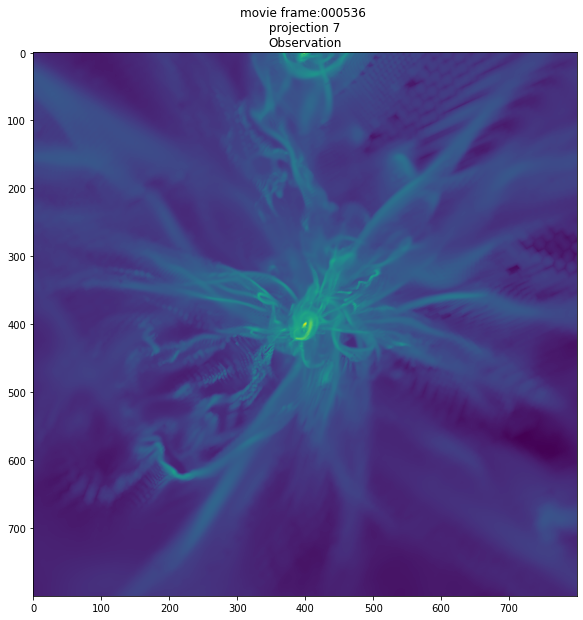

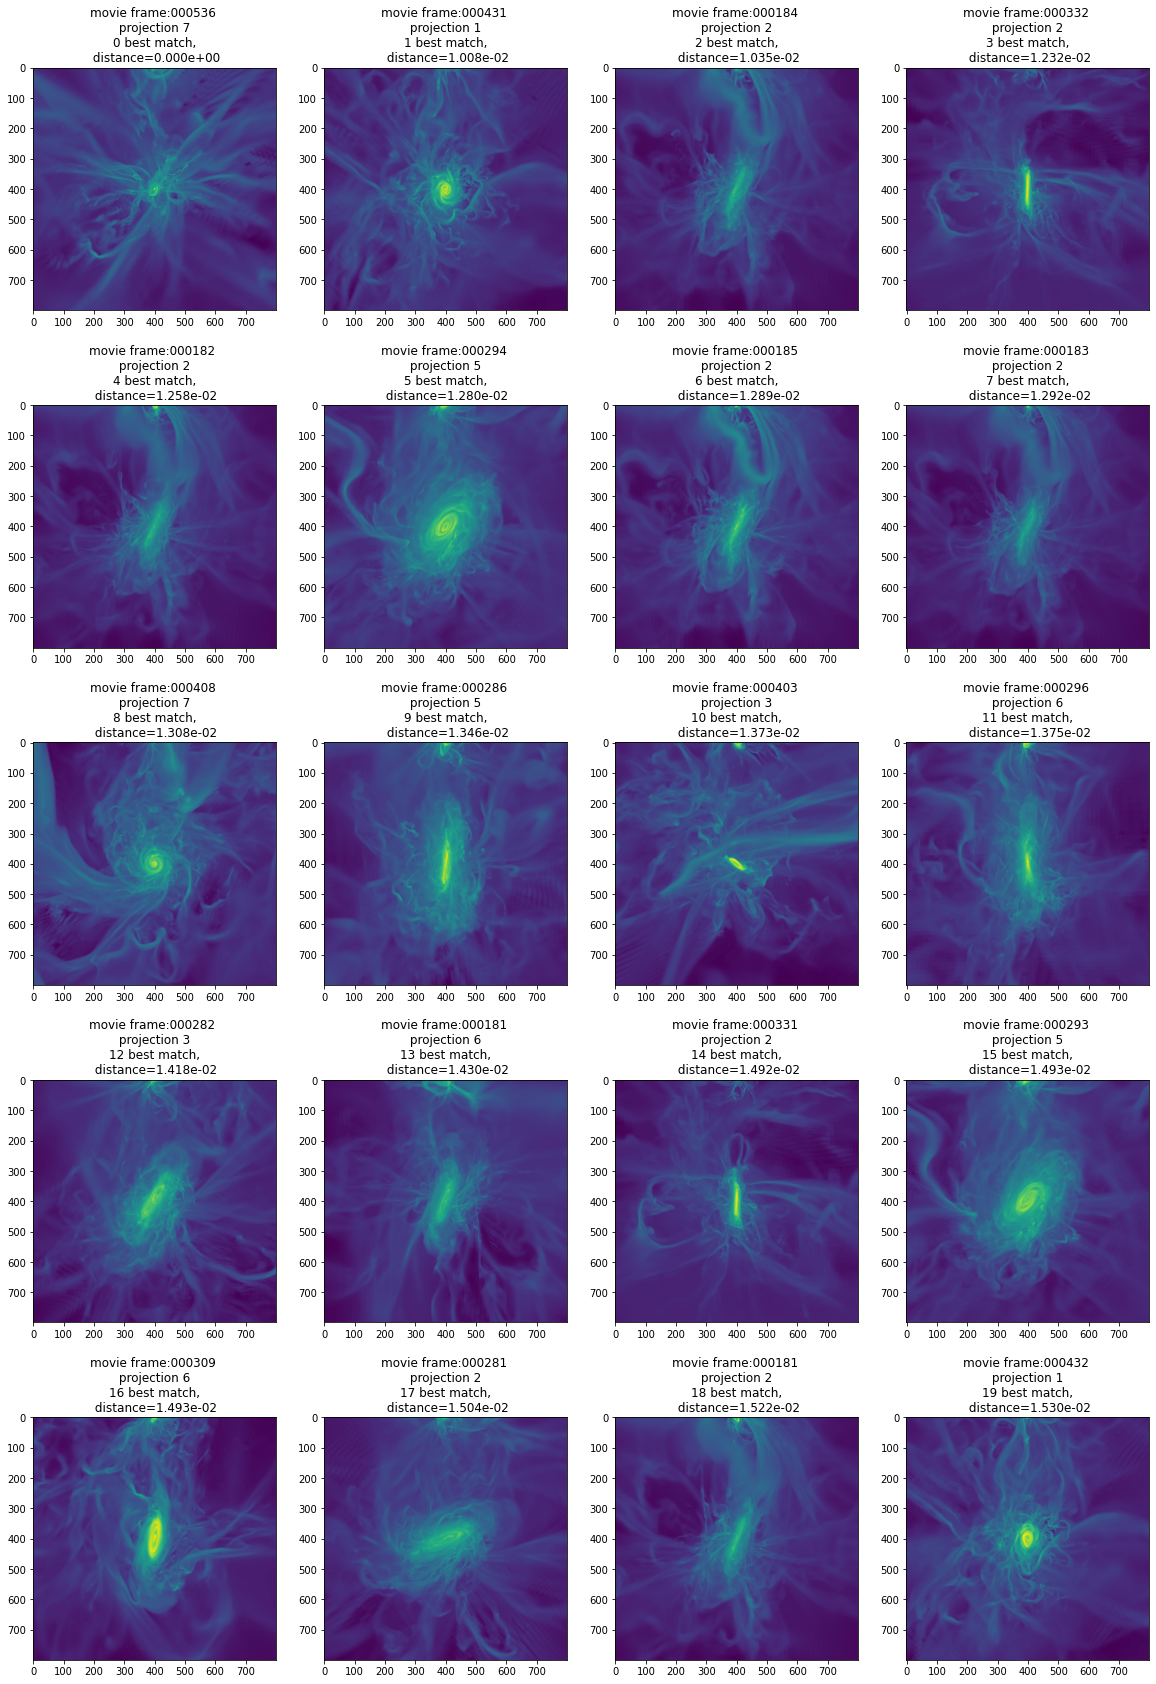

In [5]:

tik1=time.time()
best_matches=Image_search(pickle_path='/data/scratch/rami/features/vgg16/feature_frame000536/projection_7.pkl',pickles_path='/data/scratch/rami/features/vgg16/',max_num_pickles=3072,\
                 model_name='vgg19',\
                 distance_metric='knn',k=20,use_PCA=False,n_components=500,\
                 use_timing=False, display_output=True,\
                 save_best_matches=False, best_matches_folder='/lustre/hpc/astro/rami/images/')



tik2=time.time()

print('Cell run time=',(tik2-tik1))  

['/data/scratch/rami/features/vgg16/feature_frame000536/projection_7.pkl', '/data/scratch/rami/features/vgg16/feature_frame000431/projection_1.pkl', '/data/scratch/rami/features/vgg16/feature_frame000184/projection_2.pkl', '/data/scratch/rami/features/vgg16/feature_frame000332/projection_2.pkl', '/data/scratch/rami/features/vgg16/feature_frame000182/projection_2.pkl', '/data/scratch/rami/features/vgg16/feature_frame000294/projection_5.pkl', '/data/scratch/rami/features/vgg16/feature_frame000185/projection_2.pkl', '/data/scratch/rami/features/vgg16/feature_frame000183/projection_2.pkl', '/data/scratch/rami/features/vgg16/feature_frame000408/projection_7.pkl', '/data/scratch/rami/features/vgg16/feature_frame000286/projection_5.pkl', '/data/scratch/rami/features/vgg16/feature_frame000403/projection_3.pkl', '/data/scratch/rami/features/vgg16/feature_frame000296/projection_6.pkl', '/data/scratch/rami/features/vgg16/feature_frame000282/projection_3.pkl', '/data/scratch/rami/features/vgg16/fe

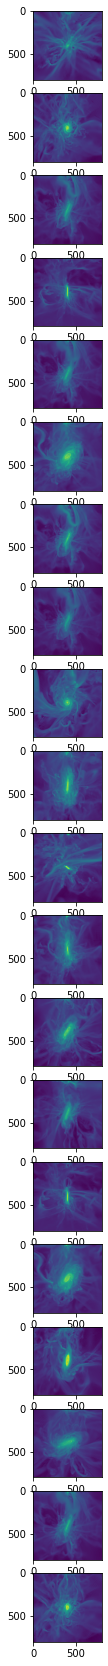

In [6]:




print(best_matches)
path_reggie='/lustre/astro/rlk/Image_only_pickles/Sink_91_HR'
plt.figure(figsize=(10,30))
j=0
for match in  best_matches:
    frame=match[-23:-17]
    projection=match[-5:-4]
    file=path_reggie+'/movie_frame_'+frame+'/projection_'+projection+'.pkl'
    print(file)
    j+=1
    img=load_pickle(file=file)
    plt.subplot(len(best_matches),1,j)
    plt.imshow(img**0.1)

### Just plotting the images on their own cell

### 


In [7]:
name='/data/scratch/rami/features/vgg16/feature_frame000247/projection_3.pkl'
print(name[-23:-17])
print(name[-5:-4])

000247
3


In [8]:
reduced_feature=np.ones(20)
reduced_features=np.random.rand(10,20)
print(reduced_features.shape)
print(np.shape(reduced_feature))
print(np.shape(reduced_features))
reduced_feature=reduced_features[5,:]
k=10

distances,idx_closest=get_neighbors(feature_vector=reduced_feature,feature_vectors=reduced_features,k=k)
print(distances)
print(idx_closest)

(10, 20)
(20,)
(10, 20)
[0.         1.81895955 1.84517328 1.86848509 1.89206105 1.90649355
 1.92950685 1.93440268 2.00806926 2.20752925]
[5 7 6 1 9 8 3 2 4 0]
